In [1]:
import boto3
import json

In [2]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt

In [3]:
client = boto3.client('logs')

In [4]:
logGroupName='/aws/sagemaker/TrainingJobs'
logStreamName='dr-sm-rltj--20191002101606-325b7ca3-edd8-4654-b15d-97d47a2b8a21/algo-1-1570011477'
file_name = logStreamName.split('/')[0]

In [5]:
logs = json.load(open(f'{file_name}.json'))

In [6]:
if logs is None:
    logs = client.filter_log_events(logGroupName=logGroupName, 
                             logStreamNames=[logStreamName], 
                             limit=10000)
    file = open(f'{file_name}.json', 'w')
    json.dump(logs, file)
    file.close()

In [7]:
logs.keys()

dict_keys(['events', 'searchedLogStreams', 'ResponseMetadata'])

In [8]:
df = pd.DataFrame(logs['events'])[['message', 'timestamp']]

In [11]:
# df = pd.read_csv('logs-insights-results.csv')[::-1]
# dt = datetime.datetime.strptime('2019-10-02 14:20:28.826', '%Y-%m-%d %H:%M:%S.%f')
# df['timestamp'] = df['@timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').timestamp())

In [12]:
df.head()

,message,timestamp
0,"2019-10-02 10:18:24,047 sagemaker-containers I...",1570011506465
1,"2019-10-02 10:18:24,048 sagemaker_bootstrap IN...",1570011506465
2,"2019-10-02 10:18:24,048 sagemaker_bootstrap IN...",1570011506465
3,"2019-10-02 10:18:24,048 sagemaker_bootstrap IN...",1570011506465
4,Starting sage-train.sh,1570011506465


In [13]:
df['type'] = df['message'].apply(lambda x: x.split('>')[0])

In [16]:
actions = ['Policy training', 'Checkpoint', 'Training']

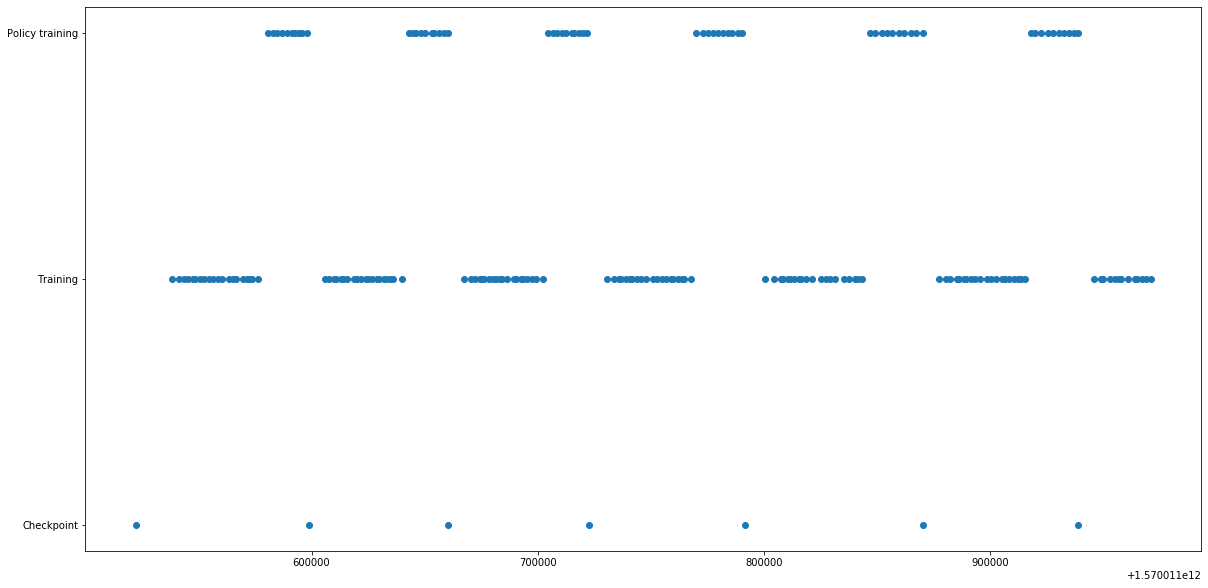

In [20]:
plt.figure(figsize=(20,10))
window = 200
plt.scatter(df[df['type'].isin(actions)]['timestamp'].values[:window], df[df['type'].isin(actions)]['type'].values[:window], marker='o')
plt.show()

# Episodes Training

In [21]:
df[df['type']=='Training'].head()

,message,timestamp,type
36,"Training> Name=main_level/agent, Worker=0, Epi...",1570011538476,Training
37,"Training> Name=main_level/agent, Worker=0, Epi...",1570011541477,Training
38,"Training> Name=main_level/agent, Worker=0, Epi...",1570011543478,Training
39,"Training> Name=main_level/agent, Worker=0, Epi...",1570011545478,Training
40,"Training> Name=main_level/agent, Worker=0, Epi...",1570011547479,Training


In [23]:
columns = [X.split('=')[0] for X in df[df['type']=='Training']['message'].iloc[0].replace('Training> ', '').replace(' ', '').split(',')][1:]
train_message_splitted = np.array(list(map(lambda x: [X.split('=')[1] for X in x.replace('Training> ', '').replace(' ', '').split(',')][1:], 
    df[df['type']=='Training']['message'].values)), dtype=float)

print(columns)

['Worker', 'Episode', 'Totalreward', 'Steps', 'Trainingiteration']


In [24]:
df[df['type']=='Training']['timestamp'].values

array([1570011538476, 1570011541477, 1570011543478, ..., 1570025856846,
       1570025864848, 1570025870857])

In [25]:
Training_df =  pd.DataFrame(data=train_message_splitted, columns=columns)
Training_df['Timestamp'] = df[df['type']=='Training']['timestamp'].values
Training_df['diff_steps'] = np.hstack([[0], Training_df['Steps'][1:].values - Training_df['Steps'][:-1].values])

In [26]:
Training_df.head()

,Worker,Episode,Totalreward,Steps,Trainingiteration,Timestamp,diff_steps
0,0.0,1.0,13.21,22.0,0.0,1570011538476,0.0
1,0.0,2.0,12.61,50.0,0.0,1570011541477,28.0
2,0.0,3.0,12.92,74.0,0.0,1570011543478,24.0
3,0.0,4.0,12.49,95.0,0.0,1570011545478,21.0
4,0.0,5.0,4.60,111.0,0.0,1570011547479,16.0


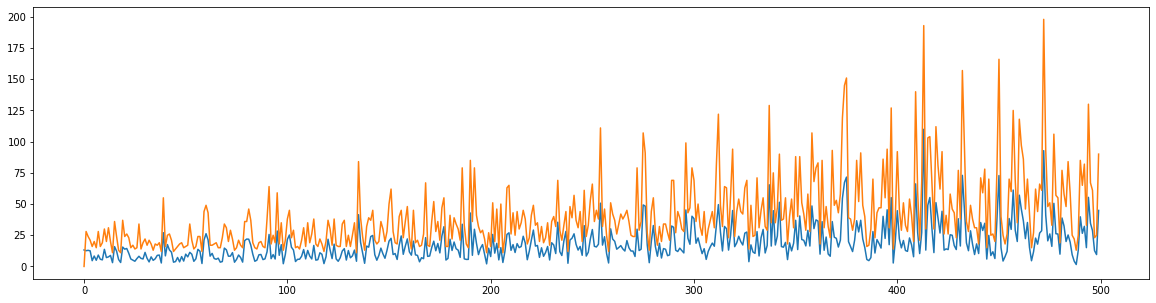

In [27]:
plt.figure(figsize=(20,5))
plt.plot(Training_df['Totalreward'].values[:500])
plt.plot(Training_df['diff_steps'].values[:500])
plt.show()

# Policy Training

In [28]:
df[df['type']=='Policy training'].head()

,message,timestamp,type
56,Policy training> Surrogate loss=-0.02190346457...,1570011580645,Policy training
57,Policy training> Surrogate loss=-0.02525260299...,1570011582745,Policy training
58,Policy training> Surrogate loss=-0.02290662191...,1570011584796,Policy training
59,Policy training> Surrogate loss=-0.06292925029...,1570011586959,Policy training
60,Policy training> Surrogate loss=-0.00614003837...,1570011589001,Policy training


In [29]:
columns_policy = [X.split('=')[0] for X in df[df['type']=='Policy training']['message'].iloc[0].replace('Policy training> ', '').replace(' ', '').split(',')]
policy_message_splitted = np.array(list(map(lambda x: [X.split('=')[1] for X in x.replace('Policy training> ', '').replace(' ', '').split(',')], 
    df[df['type']=='Policy training']['message'].values)), dtype=float)

In [30]:
print(columns_policy)

['Surrogateloss', 'KLdivergence', 'Entropy', 'trainingepoch', 'learning_rate']


In [31]:
Policy_Training_df =  pd.DataFrame(data=policy_message_splitted, columns=columns_policy)
Policy_Training_df['Timestamp'] = df[df['type']=='Policy training']['timestamp'].values 

In [33]:
Policy_Training_df.head()

,Surrogateloss,KLdivergence,Entropy,trainingepoch,learning_rate,Timestamp
0,-0.021903,0.000159,2.707184,0.0,0.00003,1570011580645
1,-0.025253,0.001013,2.706419,1.0,0.00003,1570011582745
2,-0.022907,0.002592,2.705006,2.0,0.00003,1570011584796
3,-0.062929,0.004996,2.702775,3.0,0.00003,1570011586959
4,-0.006140,0.007683,2.700323,4.0,0.00003,1570011589001


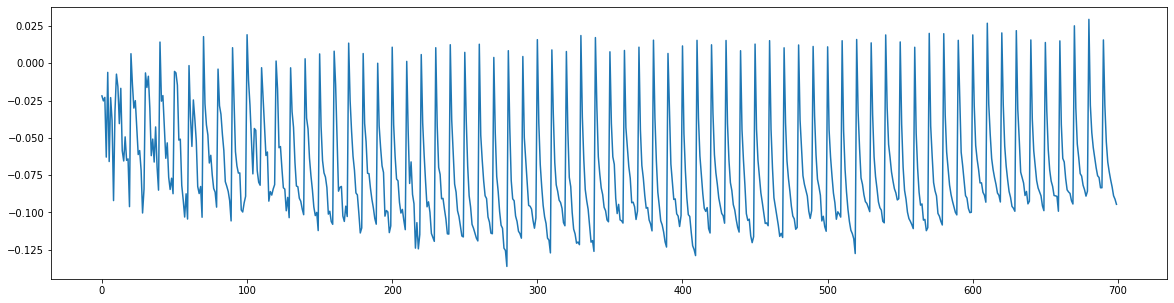

In [34]:
plt.figure(figsize=(20,5))
plt.plot(Policy_Training_df['Surrogateloss'])
plt.show()

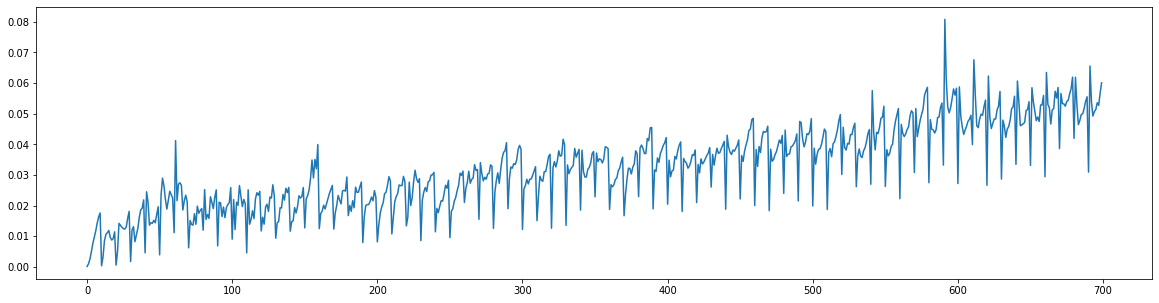

In [35]:
plt.figure(figsize=(20,5))
plt.plot(Policy_Training_df['KLdivergence'])
plt.show()

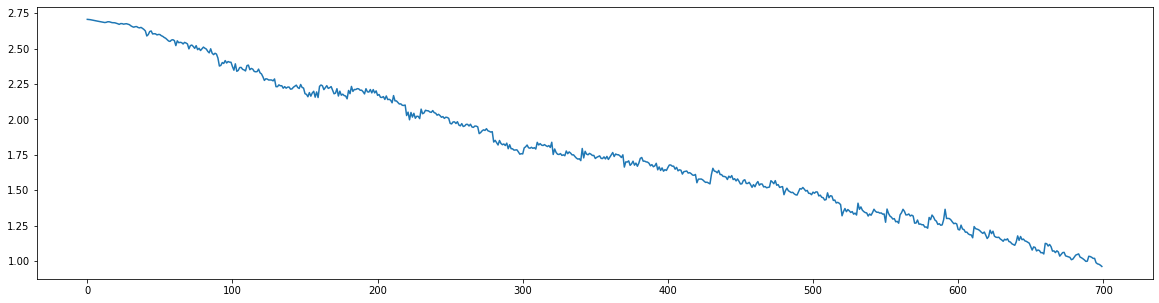

In [36]:
plt.figure(figsize=(20,5))
plt.plot(Policy_Training_df['Entropy'])
plt.show()

In [2]:
import math
def reward_function(params):
    track_width = params['track_width']
    distance_from_center = params['distance_from_center'] # distance in meters from the track center 
    steering = abs(params['steering_angle'])
    direction_stearing=params['steering_angle']
    speed = params['speed']
    steps = params['steps'] # number steps completed
    progress = params['progress'] # percentage of track completed
    all_wheels_on_track = params['all_wheels_on_track'] # flag to indicate if the vehicle is on the track
    
    # Read input variables
    waypoints = params['waypoints']
    closest_waypoints = params['closest_waypoints']
    heading = params['heading'] # vehicle's yaw in degrees
    
    reward = 1.0
    
    if progress == 100:
        reward += 100
    
    # Calculate the direction of the center line based on the closest waypoints
    next_point = waypoints[closest_waypoints[1]]
    prev_point = waypoints[closest_waypoints[0]]
    # Calculate the direction in radius, arctan2(dy, dx), the result is (-pi, pi) in radians
    track_direction = math.atan2(next_point[1] - prev_point[1], next_point[0] - prev_point[0]) 
    # Convert to degree
    track_direction = math.degrees(track_direction)
    # Calculate the difference between the track direction and the heading direction of the car
    direction_diff = abs(track_direction - heading)
    # Penalize the reward if the difference is too large
    DIRECTION_THRESHOLD = 10.0
    
    malus=1
    
    if direction_diff > DIRECTION_THRESHOLD:
        malus=1-(direction_diff/50)
        if malus<0 or malus>1:
            malus = 0
        reward *= malus
    
    reward *= speed/12
    
    return reward

In [ ]:

    "x": float,                        # vehicle's x-coordinate in meters
    "y": float,                        # vehicle's y-coordinate in meters
    "is_left_of_center": Boolean,      # Flag to indicate if the vehicle is on the left side to the track center or not. 
    "heading": float,                  # vehicle's yaw in degrees
    "progress": float,                 # percentage of track completed
    "steps": int,                      # number steps completed
    "speed": float,                    # vehicle's speed in meters per second (m/s)
    "steering_angle": float,          # vehicle's steering angle in degrees
    "track_width": float,              # width of the track
    "waypoints": [[float, float], … ], # list of [x,y] as milestones along the track center
    "closest_waypoints": [int, int]    # indices of the two nearest waypoints.
}

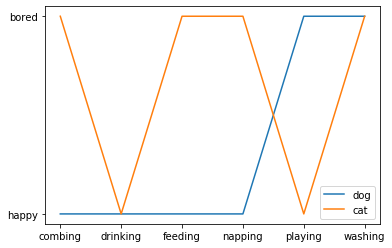

In [67]:
cat = ["bored", "happy", "bored", "bored", "happy", "bored"]
dog = ["happy", "happy", "happy", "happy", "bored", "bored"]
activity = ["combing", "drinking", "feeding", "napping", "playing", "washing"]

fig, ax = plt.subplots()
ax.plot(activity, dog, label="dog")
ax.plot(activity, cat, label="cat")
ax.legend()

plt.show()

In [ ]:
w